In [2]:
import logging
from typing import Any, Callable, List, Literal, Type, Dict, Union
from pathlib import Path
import argparse
import glob
import pickle
import os
import json
import mteb

import numpy as np
import torch
import mteb

from utils.misc.model_dataloader_utils import get_model_path, model_name_to_sizes
from utils.model_definitions.mteb_automodel_wrapper import AutoModelWrapper, ModelSpecifications

In [50]:
def handle_special_mteb_results(data):
    special_benchmarks = ['STS17', 'AmazonCounterfactualClassification']

    if data.get('task_name') not in special_benchmarks:
        assert len(data.get('scores').get('test')) == 1, \
            f"Expected 1 score for {data.get('task_name')}, got {len(data.get('scores').get('test'))}"
        
        return data.get('scores').get('test')[0].get('main_score')
    
    if data.get('task_name') == 'STS17':
        scores = data.get('scores', {}).get('test', [])
        filtered_scores = [
            score for score in scores 
            if score.get('languages') == ['eng-Latn']
        ]
        assert len(filtered_scores) == 1
        return filtered_scores[0].get('main_score')

    elif data.get('task_name') == 'AmazonCounterfactualClassification':
        scores = data.get('scores', {}).get('test', [])
        filtered_scores = [
            score for score in scores 
            if score.get('hf_subset') in ['en', 'en-ext']
        ]
        assert len(filtered_scores) == 2

        english_score = filtered_scores[0].get('main_score')
        english_ext_score = filtered_scores[1].get('main_score') # harder superset, described in Sec 3.3 of https://aclanthology.org/2021.emnlp-main.568.pdf

        return (english_score + english_ext_score) / 2
    else:
        raise ValueError(f"Special benchmark handling for {data.get('task_name')} not found")
    
def get_task_type_from_task_name(task_name: str):
    mteb_task = mteb.get_task(task_name)
    return mteb_task.metadata.type
        
def load_layerwise_results_for_specific_model(model_specs: ModelSpecifications, dataloader_kwargs):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    dataset = dataloader_kwargs['dataset_name']

    results = {}
    results['metrics'] = {}
    wikitext_load_dir = f"results/{model_family}/{model_size}/{revision}/metrics/{dataset}/"
    for file_path in glob.glob(f"{wikitext_load_dir}/*.pkl"):
        with open(file_path, "rb") as f:
            key = os.path.basename(file_path)[:-4]
            results['metrics'][key] = pickle.load(f)
    
    mteb_load_dir = f"results/{model_family}/{model_size}/{revision}/mteb/"
    results['mteb'] = {}
    for layer_dir in glob.glob(f"{mteb_load_dir}/layer_*"):
        for json_file in glob.glob(f"{layer_dir}/*.json"):
            dataset_name = os.path.basename(json_file)[:-5]
            
            if dataset_name == 'model_meta':
                continue

            if dataset_name not in results['mteb']:
                results['mteb'][dataset_name] = {}
                results['mteb'][dataset_name]['scores'] = []

            with open(json_file, 'r') as f:
                data = json.load(f)
                main_score = handle_special_mteb_results(data)
                results['mteb'][dataset_name]['scores'].append(main_score)

                if 'task_type' not in results['mteb'][dataset_name]:
                    results['mteb'][dataset_name]['task_type'] = get_task_type_from_task_name(dataset_name)
    return results

In [67]:
model_family = 'Pythia'
model_size = '160m'
revision = 'main'

model_specs = ModelSpecifications(model_family, model_size, revision=revision)
results = load_layerwise_results_for_specific_model(model_specs, {'dataset_name': 'wikitext'})

# plotting

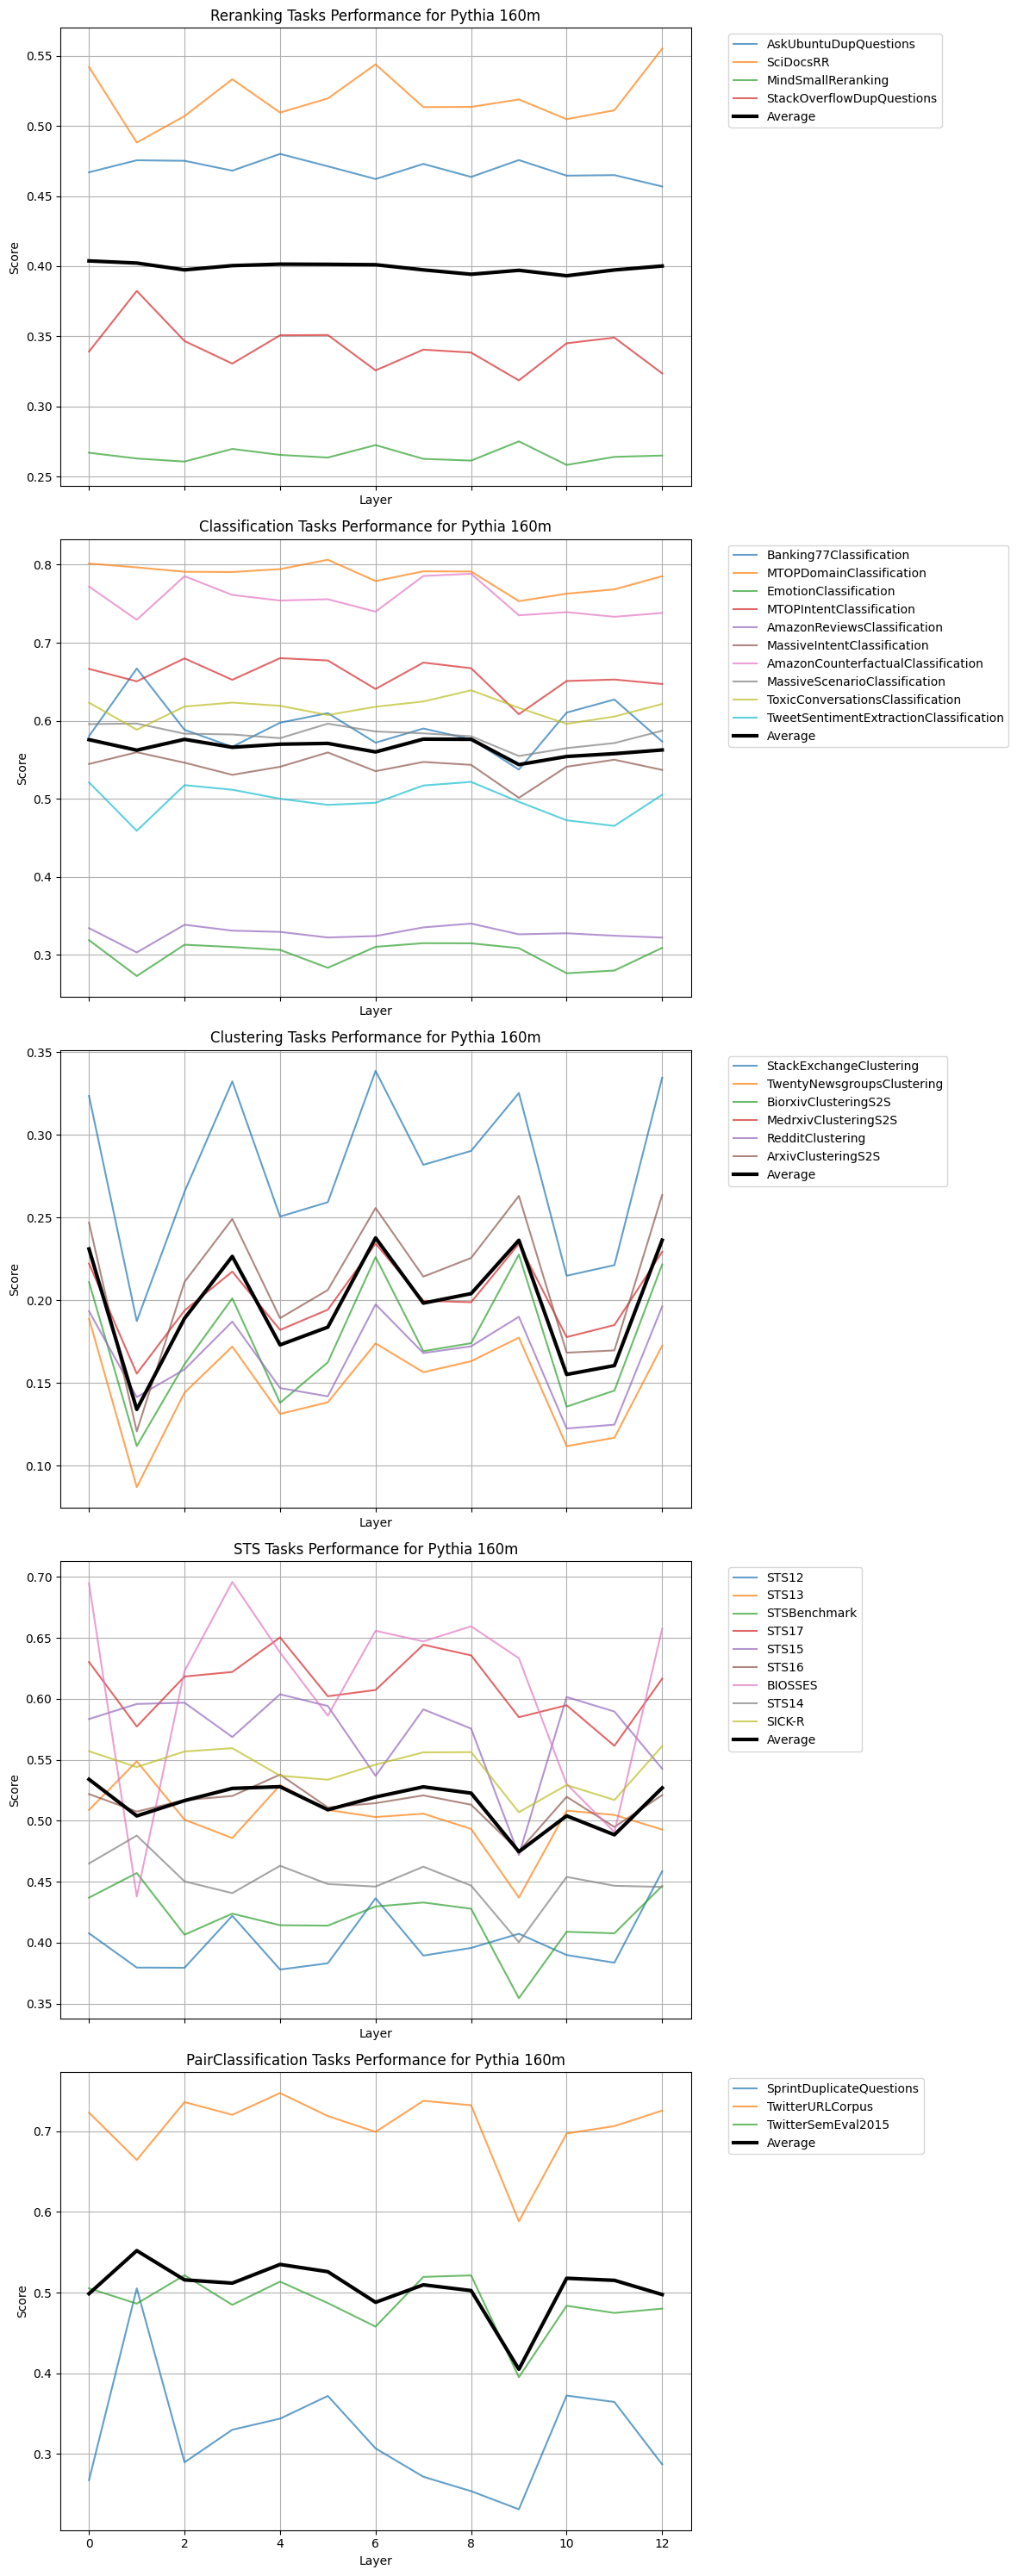

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Group tasks by task type
task_types = {}
for task, data in results['mteb'].items():
    task_type = data['task_type']
    if task_type not in task_types:
        task_types[task_type] = {}
    task_types[task_type][task] = data

# Create subplots
num_task_types = len(task_types)
fig, axs = plt.subplots(num_task_types, 1, figsize=(12, 6*num_task_types), sharex=True)

for i, (task_type, tasks) in enumerate(task_types.items()):
    ax = axs[i] if num_task_types > 1 else axs
    all_scores = []
    
    for task, data in tasks.items():
        scores = data['scores']
        layers = range(len(scores))
        ax.plot(layers, scores, label=task, alpha=0.7)
        all_scores.append(scores)
    
    # Calculate and plot the average line
    if all_scores:
        average_scores = np.mean(all_scores, axis=0)
        ax.plot(layers, average_scores, label='Average', linewidth=3, color='black')
    
    ax.set_xlabel('Layer')
    ax.set_ylabel('Score')
    ax.set_title(f'{task_type} Tasks Performance for {model_family} {model_size}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


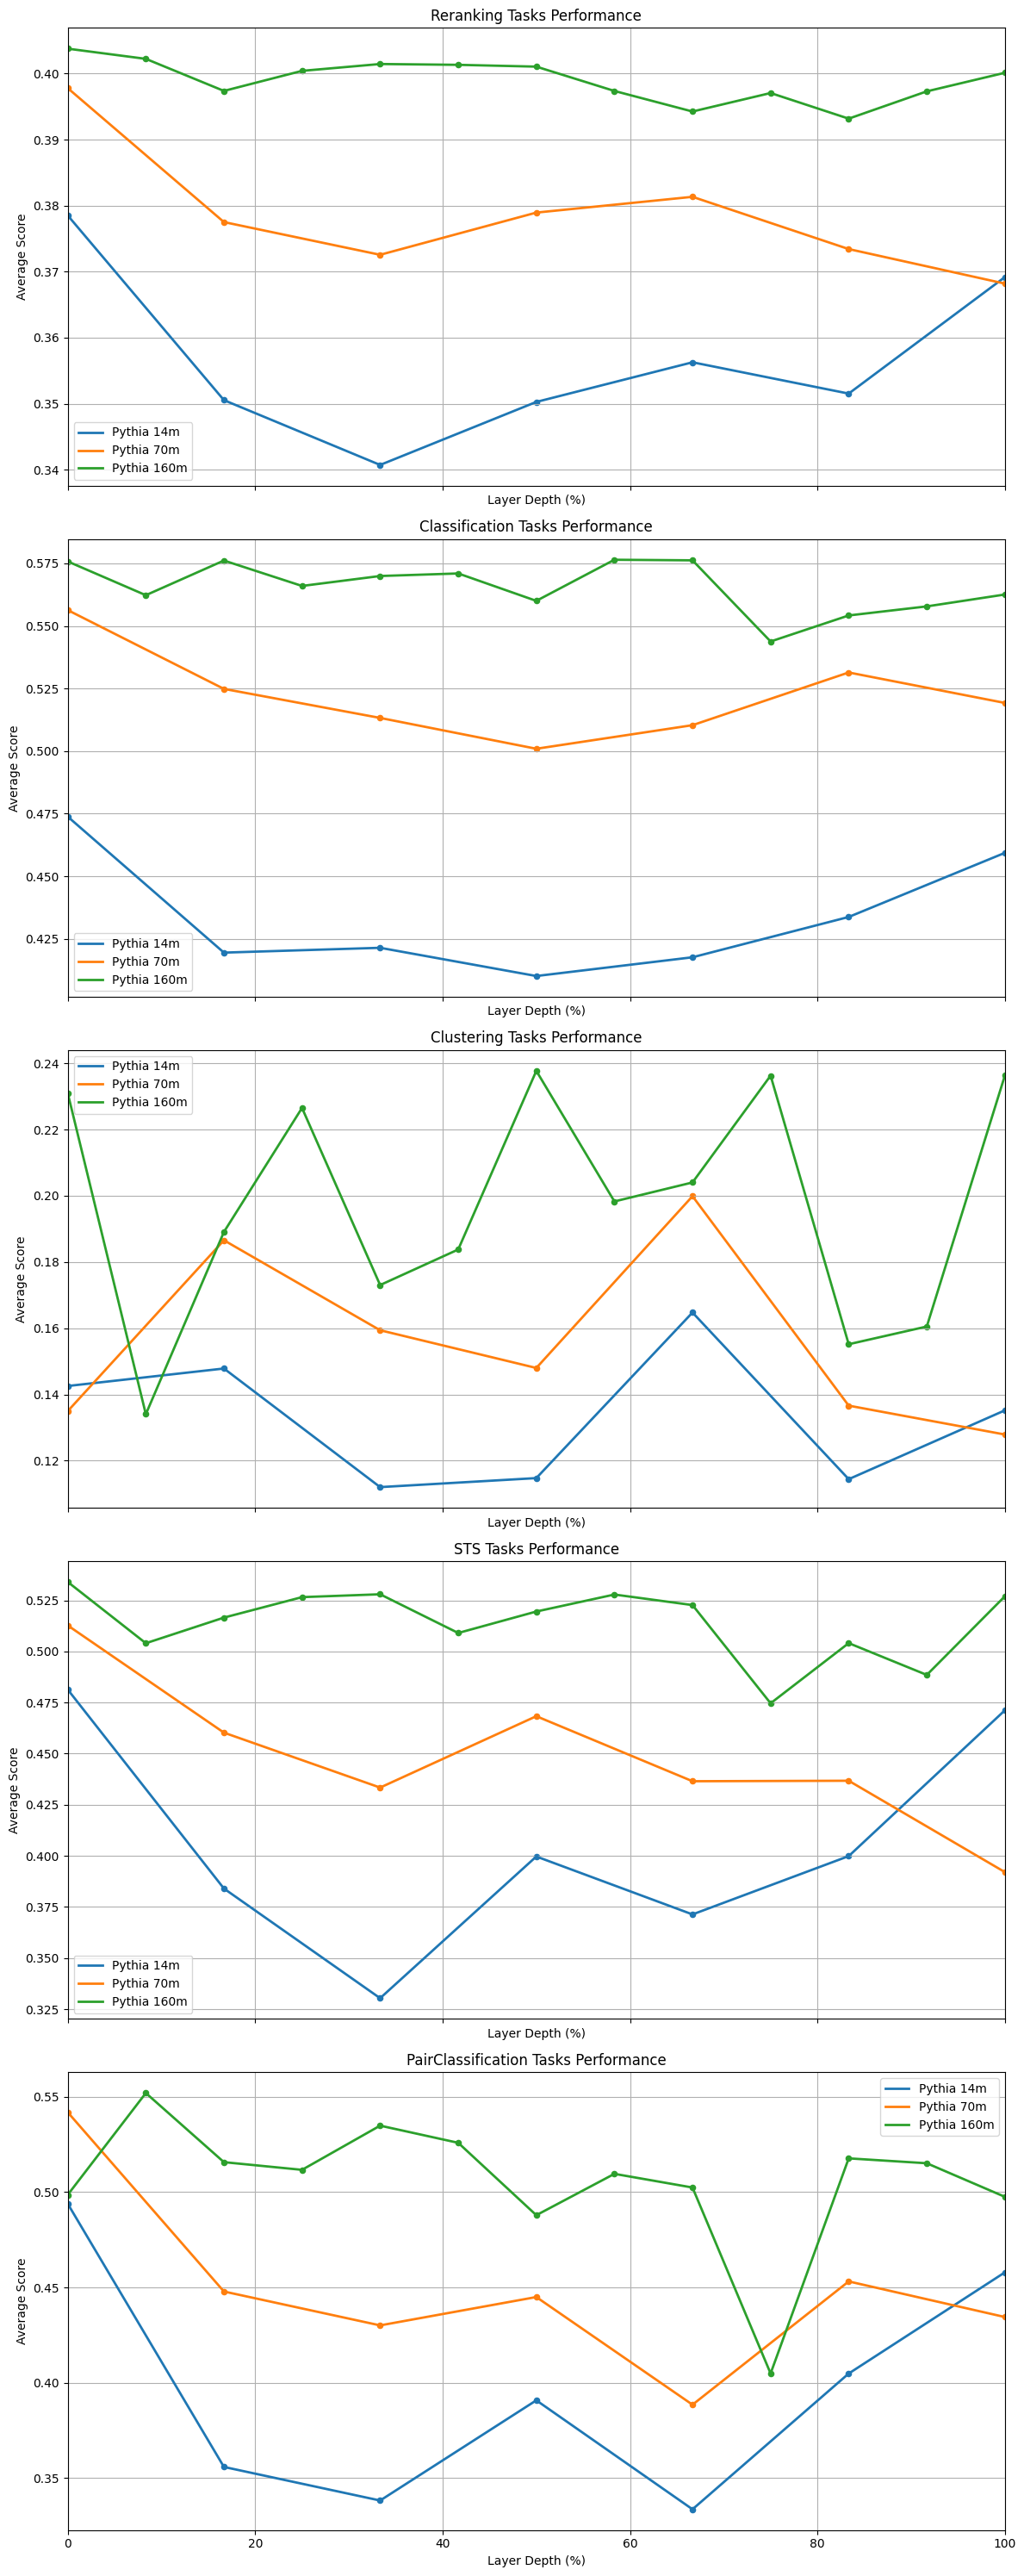

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load results for each model size
model_sizes = ['14m', '70m', '160m']
results = {}

for size in model_sizes:
    results[size] = load_layerwise_results_for_specific_model(ModelSpecifications(model_family, size, revision=revision), {'dataset_name': 'wikitext'})

# Group tasks by task type
task_types = {}
for size in model_sizes:
    for task, data in results[size]['mteb'].items():
        task_type = data['task_type']
        if task_type not in task_types:
            task_types[task_type] = {}
        if task not in task_types[task_type]:
            task_types[task_type][task] = {}
        task_types[task_type][task][size] = data

# Create subplots
num_task_types = len(task_types)
fig, axs = plt.subplots(num_task_types, 1, figsize=(12, 6*num_task_types), sharex=True)

for i, (task_type, tasks) in enumerate(task_types.items()):
    ax = axs[i] if num_task_types > 1 else axs
    
    for size in model_sizes:
        all_scores = []
        max_layers = 0
        for task, size_data in tasks.items():
            if size in size_data:
                scores = size_data[size]['scores']
                max_layers = max(max_layers, len(scores))
                all_scores.append(scores)
        
        # Calculate and plot the average line and points for each size
        if all_scores:
            average_scores = np.mean(all_scores, axis=0)
            layers_percentage = np.linspace(0, 100, len(average_scores))
            ax.plot(layers_percentage, average_scores, linewidth=2, label=f'{model_family} {size}')
            ax.scatter(layers_percentage, average_scores, s=20)
    
    ax.set_xlabel('Layer Depth (%)')
    ax.set_ylabel('Average Score')
    ax.set_title(f'{task_type} Tasks Performance')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()
